# Classification of handwritten digits using TensorFlow

## About this notebook:

- MNIST - dataset of handwritten digits
- Simple classification using softmax regression
- Increasing the accuracy by implementing a convolutional neural network



### MNIST - dataset of handwritten digits

- Available on the Web and free to use.
- Contains 60000 images of handwritten digits from 0 to 9.
- Images are grayscale (1 color channel) with a resolution of 28 x 28 pixels.
- Images are flattened into an array of 784 float numbers - one number per pixel.    
- The dataset is split into training (55000) a test (5000) subset.
- The dataset is labelled - each image contains the correct label. 

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


### Few examples from the dataset

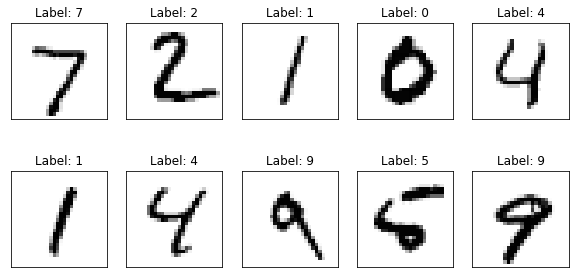

In [3]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
%matplotlib inline

fig = plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    example = mnist.test.images[i]
    example_label = "Label: %s"%[a for a,b in enumerate(mnist.test.labels[i]) if b == 1][0]
    plt.title(example_label)
    plt.imshow(example.reshape([28,28]), cmap = cm.Greys)
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)
plt.show()

## Simple classifier using softmax regression

We will start with a simple softmax regression model for our first classifier.

But first let's import TensorFlow and create a session.

### TensorFlow InteractiveSession

- TensorFlow is a library for numerical calculations developed by the Google's Brain team.
- Currently it has been open sourced and is one of the most popular projects on Github.
- It is based on the data flow graph principle.
- All calculation operations are stored in a graph to be executed later.
- To execute an operation we have to create a TensorFlow session.
- InteractiveSession is an abstraction of the Session - simplifies the usage of the API.

In [4]:
import tensorflow as tf
sess = tf.InteractiveSession()
print("Tensorflow version: %s"%tf.__version__)

Tensorflow version: 1.1.0


### Placeholders - entry points to our model

To be able to feed the model with external data we have to specify our placeholder variables.

- **x**  image arrays of 784 elements from the MNIST dataset
- **y_** correct labels from the MNIST dataset   

In [5]:
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

### Model variables

These are the local variables that our model will use for it's calculations. 
They are automatically updated as the model is getting trained.

- **W** - weights - is a matrix of weights, with the dimension of 784 x 10 (pixel x digit)
- **b** - bias - population parameter, some digits are less present than others in the dataset. Bias captures these differences and moves the slope to get correct prediction not based on the amounts of a digit in the training data.

In [6]:
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))

### Variable initialization

Before we start to train our model we have to initialize our variables.

In [7]:
sess.run(tf.global_variables_initializer())

### Linear model (Score function)

Our linear model is quite simple.
We will multiply our input data with the weights and add bias.

### y = x*W + b
  

In [9]:
y = tf.add(tf.matmul(x,W), b)

### Softmax cost function

We are using cost function to measure how close are the predicted labels to their corresponding real labels from the dataset.

Softmax is basically a normalized exponential function.
Cross entropy - function to calculate "unnatural" probability distribution.

Tensorflow has a handy function wich combines softax and cross entropy into a single call.

- **tf.nn.softmax_cross_entropy_with_logits** - handy function built into TensorFlow
- **tf.reduce_mean** - arithmetic mean from all the categories

### Visualize the softmax function

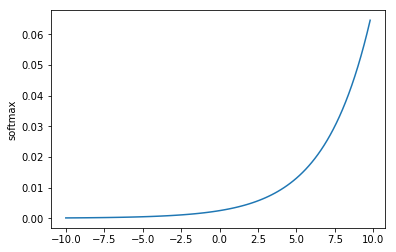

In [11]:
import numpy as np
npa = np.array
def softmax(w, t = 3.0):
    e = np.exp(npa(w) / t)
    dist = e / np.sum(e)
    return dist

arr = np.arange(-10., 10., 0.2)
sig = softmax(arr)

plt.plot(arr, sig)
plt.ylabel('softmax')
plt.show()

### Define our cross entropy

In [12]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y, labels=y_))

### Training of the model

The optimizer is an algorithm, that is responsible for minimizing our cost function by adjusting the Weight (W) and bias (b) variables.

Gradient descent - is an iterative algorithm that calculates the steepest descent towards the minimum and then adjusts the values according to the step ratio.

- We are using the built-in **GradientDescentOptimizer** with the step size of 0.5.
- We are spliting our input into batches of 100 images.

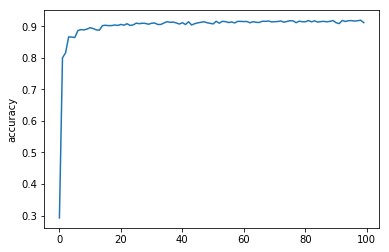

In [13]:
# define functions to measure accuracy
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# store accuracies in a list
acc_steps = []

# define our train step using the Gradient Descent Optimizer
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

# training iterations
for i in range(1000):
    batch = mnist.train.next_batch(100)
    train_step.run(feed_dict={x: batch[0], y_: batch[1]})
    if i%10==0:        
        acc_steps.append(accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))
    
# visualize accuracy
plt.plot(acc_steps)
plt.ylabel('accuracy')
plt.show()

### Accuracy of the model

In [19]:
print("Accuracy %.f%%"%((acc_steps[-1])*100))

Accuracy 91%


### Visualize the weights

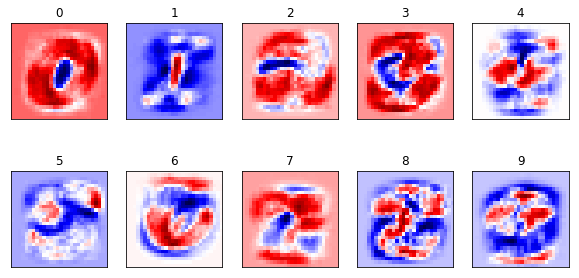

In [20]:
fig = plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    weight = sess.run(W)[:,i]
    plt.title(i)
    plt.imshow(weight.reshape([28,28]), cmap=plt.get_cmap('seismic'))
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)
plt.show()

## Improving the accuracy using a Convolutional Neural Network

Our CNN architecture is as follows:

#### INPUT -> CONV -> RELU -> POOL -> CONV -> RELU -> POOL -> FC -> SOFTMAX -> OUTPUT

- CONV - convolutional layer
- RELU - activation function
- POOL - max pooling - subsampling
- FC - fully connected layer
- SOFTMAX - softmax regression

### Helper functions

Let's first define some helper functions to help us build our convolutional network.

In [21]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

x_image = tf.reshape(x, [-1,28,28,1])

### First convolutional layer

- detects 32 features for each 5x5 patch.
- these layers are not densely connected - they are grouped to neighbouring regions

Our weights have the dimesion of [5, 5, 1, 32], that is:
- width of the patch
- height of the patch
- number of color channels - in our case inputs
- number of output channels - note that we will get a 3D output

In [30]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

### ReLU activation function

Rectified Linear unit - every negative number will be changed to zero.
```
f(x) = max(0,x)
```

In [31]:
h_conv1 = tf.nn.relu(tf.add(conv2d(x_image, W_conv1), b_conv1))

### Max Pooling

We are downsampling the image (lowering it's resolution) to lower the number of features and prevent overfitting.

For each 2x2 patch of the image and pick the highest value.
This will change the resolution form 28x28 to 14x14.

In [32]:
h_pool1 = max_pool_2x2(h_conv1)

### Second convolutional layer

- Almost the same as the first layer
- 5x5 patch
- 32 inputs per region
- 64 outputs per region

In [33]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

### ReLU activation for the second convolutional layer

In [34]:
h_conv2 = tf.nn.relu(tf.add(conv2d(h_pool1, W_conv2), b_conv2))

### Max Pooling 

Once again we are adding the max pooling step.
The new resolution is 7x7.

In [35]:
h_pool2 = max_pool_2x2(h_conv2)

### Fully connected layer

Fully connected layers are very common in classical neural networks.
It means that neurons from all the regions are connected together.
It enables us to detect patterns everywhere on the image not just in one specific region.

We'll get 1024 outputs.
Also we will reshape our matrix to a 1D vector with 196 values.
The reason for that is that we can then use this vector in the next softmax layer.

In [36]:
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.add(tf.matmul(h_pool2_flat, W_fc1), b_fc1))

### Dropout

Dropout helps us to reduce overfitting.

Overfiting means that our model is too bound to our training data and performs badly on new test data.

Dropout is a simple technique of excluding out random outputs from the neurons.

TensorFlow applies the Dropout automatically based on our specified keep_prob value.

We'll use it **only when training!**

In [37]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

### Softmax layer

At last we will apply our softmax regression to the output of the previous layer to predict the labels.

In [38]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.add(tf.matmul(h_fc1_drop, W_fc2), b_fc2)
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=y_))

### Training our model

<font color='red'><b>Warning: This could take several minutes on a standard PC.</b></font>

step 0, training accuracy 0.14
step 1000, training accuracy 0.94
step 2000, training accuracy 0.94
step 3000, training accuracy 1
step 4000, training accuracy 1
step 5000, training accuracy 0.98
step 6000, training accuracy 0.98
step 7000, training accuracy 1
step 8000, training accuracy 1
step 9000, training accuracy 0.98
step 10000, training accuracy 1
step 11000, training accuracy 1
step 12000, training accuracy 1
step 13000, training accuracy 1
step 14000, training accuracy 1
step 15000, training accuracy 1
step 16000, training accuracy 1
step 17000, training accuracy 1
step 18000, training accuracy 1
step 19000, training accuracy 1
test accuracy 0.991


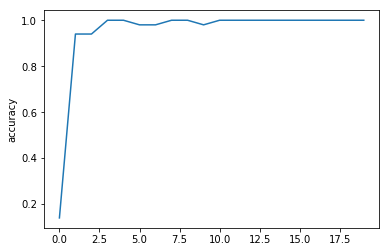

In [39]:
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.global_variables_initializer())

acc_steps = []

for i in range(20000):
    batch = mnist.train.next_batch(50)
    if i%1000 == 0:
        train_accuracy = accuracy.eval(feed_dict={
        x:batch[0], y_: batch[1], keep_prob: 1.0})
        acc_steps.append(train_accuracy)
        print("step %d, training accuracy %g"%(i, train_accuracy))
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

print("test accuracy %g"%accuracy.eval(feed_dict={
x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

# visualize accuracy
plt.plot(acc_steps)
plt.ylabel('accuracy')
plt.show()

### Classification of a single example

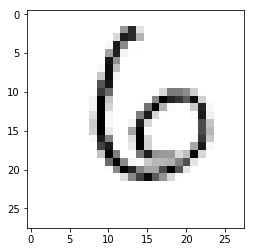

Label: [6]
Predicted Digit: [6]


In [40]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
%matplotlib inline

index = 100

tmp = mnist.test.images[index]
tmp = tmp.reshape((28,28))

plt.imshow(tmp, cmap = cm.Greys, interpolation="nearest")
plt.show()

print("Label: %s"%[a for a,b in enumerate(mnist.test.labels[index]) if b == 1])

prediction=tf.argmax(y_conv,1)
print("Predicted Digit: %s"%prediction.eval(feed_dict={x: [mnist.test.images[index]], keep_prob: 1.0}, session=sess))

### Visualization of the Activations

In [41]:
import numpy as np
import math

def getActivations(activation,example):
    units = sess.run(activation,feed_dict={x:[example],keep_prob:1.0})
    plotNNFilter(units)

def plotNNFilter(units):
    filters = units.shape[2]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap=plt.get_cmap('coolwarm'))
    plt.show()
    
example_index = index
example = mnist.test.images[example_index]
example_label = "'MNIST example: Number %s"%[a for a,b in enumerate(mnist.test.labels[example_index]) if b == 1][0]

### Activations in the first convolutional layer

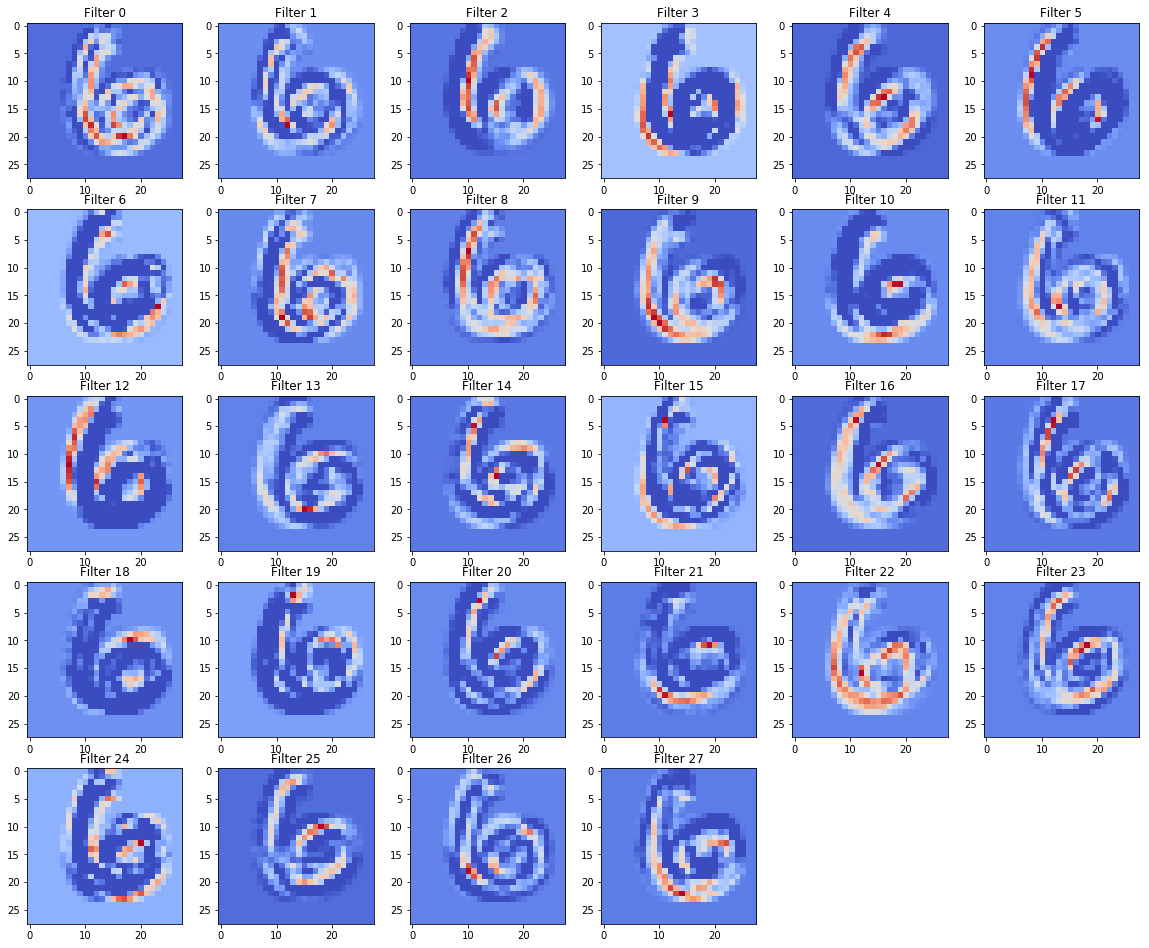

In [42]:
getActivations(h_conv1,example)

### Visualization of the first Max Pooling step

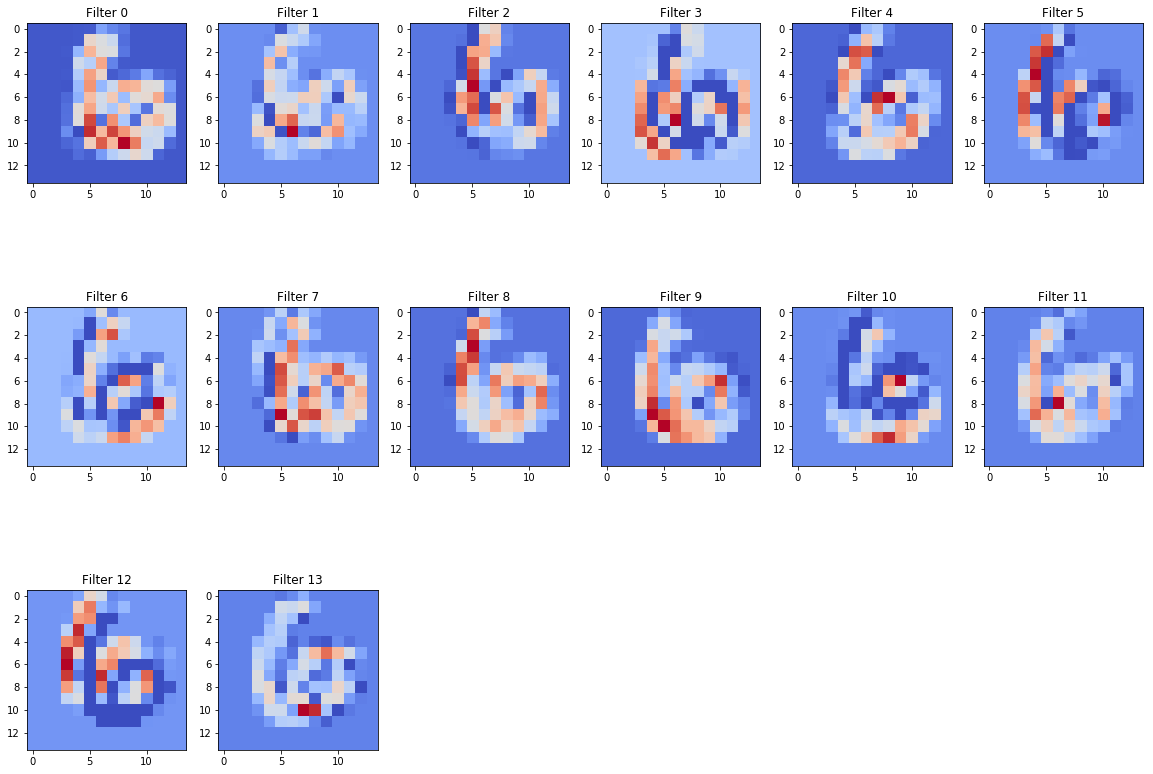

In [44]:
getActivations(h_pool1,example)

### Activations of the second convolutional layer

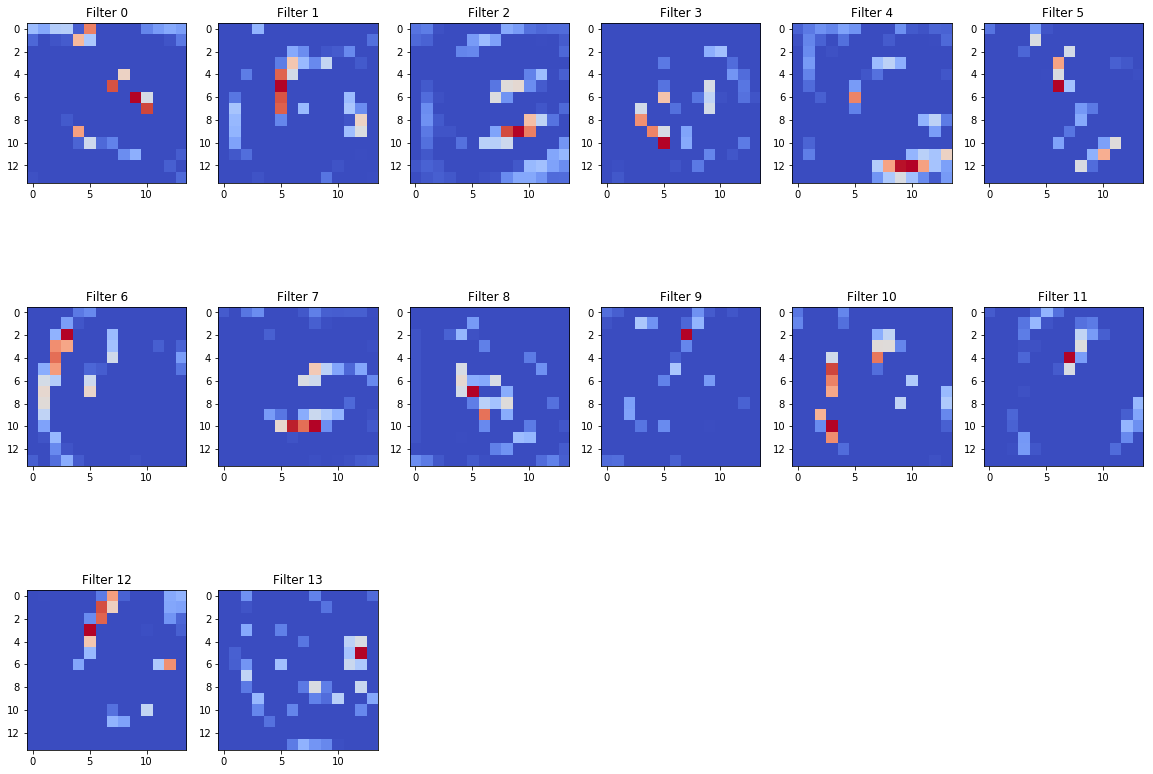

In [45]:
getActivations(h_conv2,example)

### Second Max Pooling layer

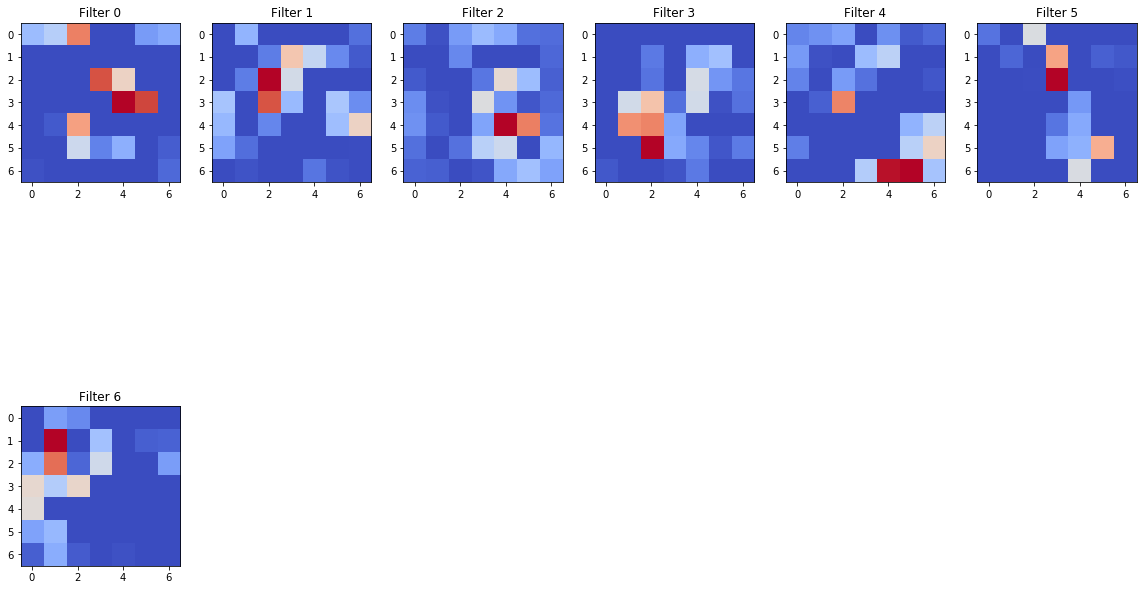

In [46]:
getActivations(h_pool2,example)